# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a seperate lengthscale for each dimension.

In [1]:
import logging
import numpy as np
from scipy.stats import gamma 

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import GeneralizedLinearModel, Parameter, Positive
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Gaussian
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

logging.basicConfig(level=logging.INFO)

### Settings

In [2]:
lenscale = gamma(2, scale=50)
regularizer = gamma(2, scale=10)
var = gamma(2, scale=50)
nbases = 8192
random_state = 100
nsamples = 10

batch_size = 10
maxiter = int(1e6)
updater = Adam()

doGP = False
m = 1024
n_restarts=1

### Load the data

In [3]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))


Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets and inputs
As per GPML p23

In [4]:
# Targets
ymean = y_train.mean()
y_train -= ymean
y_test -= ymean

# Inputs
Xscaler = StandardScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

### Initialise the algorithms

In [5]:
if not doGP:
    lenscale_init = Parameter(lenscale, Positive(), shape=(D,))
    var_init = Parameter(var, Positive())
    regularizer_init = Parameter(regularizer, Positive())

    base = RandomRBF(nbases=nbases,
                     Xdim=D,
                     lenscale=lenscale_init,
                     random_state=random_state,
                     regularizer=regularizer_init
                    )
    llhood = Gaussian(var=var_init)

    alg = GeneralizedLinearModel(llhood,
                                 base,
                                 updater=updater,
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 nsamples=nsamples,
                                 random_state=random_state
                                )
else:
    kern = 3**2 * RBF(length_scale=np.ones(D), length_scale_bounds=(1e-3, 1e7)) \
        + WhiteKernel(noise_level=1)
    alg = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)

### Train the algorithms

In [6]:
if not doGP:
    alg.fit(X_train, y_train)
else:
    rnd = np.random.RandomState(random_state)
    t_ind = rnd.choice(Ntrain, size=m, replace=False)
    alg.fit(X_train[t_ind], y_train[t_ind])


INFO:revrand.glm:Optimising parameters...
INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.glm:Random starts: Iter -500: ELBO = -820520.8555837772, reg = 24.313851361153127, like_hypers = 33.47730588874769, basis_hypers = [  76.42996497   65.56696126   25.91213202   36.27129218   25.54476686
  176.24633782   45.13426946  141.04295011  100.81517553  129.93048633
   22.55087162   27.58728302   88.12230696   14.77830918  170.05437885
   33.39068582   33.88680412   25.89050631  165.22872133   35.50657709
  141.1611294 ]
INFO:revrand.optimize.decorators:Best start found with objective = 175913.42716323075
INFO:revrand.glm:Iter 0: ELBO = -190185.47270032638, reg = 2.787835606603672, like_hypers = 213.45475536989727, basis_hypers = [  64.03741644   11.87301678  202.55498725  105.3220597    58.78719206
  155.69081931  143.7736668    74.17596277   97.36446958   14.19895062
  119.06456277  193.07321649   35.37365564  113.24485653  139.37789321
   56.59602865   91.3786737

### Predict and score



SMSE = 0.015176753195630645
MSLL = -1.9804475470052938


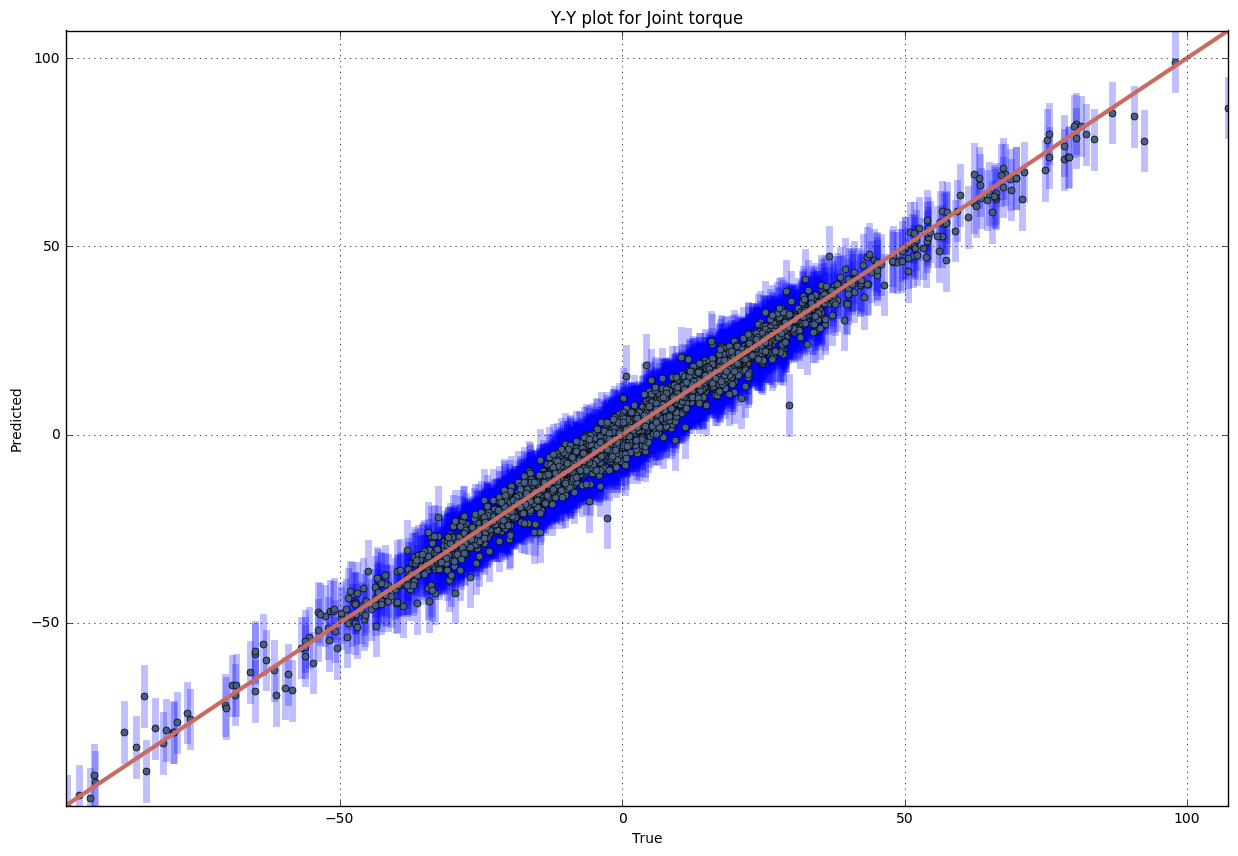

In [7]:
if not doGP:
    Ey, Vf = alg.predict_moments(X_test)
    Vy = Vf + alg.like_hypers_
    Sy = np.sqrt(Vy)
else:
    Ey, Sy = alg.predict(X_test, return_std=True)
    Vy = Sy**2

print("SMSE = {}".format(smse(y_test, Ey)))
print("MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

# YY plot
pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")